# Kickstarter: Exploration & Prediction
By:
* Cen Liang
* Mahmoud Belhaj
* Jonas Cristens

### Load the required packages

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Read the Kickstarter projects file 201801 csv and parse the dates and change the categorical columns to categories

In [96]:
df = pd.read_csv('ks-projects-201801.csv', parse_dates = ['launched', 'deadline'], index_col = 'ID')
df = df.astype({"category": 'category',
                "main_category": 'category', 
                "currency": 'category', 
                'state' : 'category', 
                'country' : 'category',
               })
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Check if there is data missing

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null category
main_category       378661 non-null category
currency            378661 non-null category
deadline            378661 non-null datetime64[ns]
goal                378661 non-null float64
launched            378661 non-null datetime64[ns]
pledged             378661 non-null float64
state               378661 non-null category
backers             378661 non-null int64
country             378661 non-null category
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: category(5), datetime64[ns](2), float64(5), int64(1), object(1)
memory usage: 31.1+ MB


There is no missing data, there in total 378661 rows and 16 columns.

In [98]:
df.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


### Check the data types

In [99]:
df.dtypes

name                        object
category                  category
main_category             category
currency                  category
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                     category
backers                      int64
country                   category
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

The dtypes are correct now we can calculate the difference in days between `launced` and `deadline`.

In [100]:
df['days_to_collect'] = (df['deadline'] - df['launched']).dt.days
df['days_to_collect'].head(5)

ID
1000002330    58
1000003930    59
1000004038    44
1000007540    29
1000011046    55
Name: days_to_collect, dtype: int64

### Average amount per day needed to reach the goal

In [101]:
# replace the inf values with 0 (0/something) = np.inf) 
df['usd_needed_per_day'] = (df['usd_goal_real'] / df['days_to_collect']).replace([np.inf, -np.inf], 0)

### What are the different Kickstarter states?

In [102]:
df['state'].unique()

[failed, canceled, successful, live, undefined, suspended]
Categories (6, object): [failed, canceled, successful, live, undefined, suspended]

We define 
* `failed`, `canceled`, `undefined` and `suspended` as failed.
* `successful` as success.
* `live` not relevant ==> will be deleted since our goal is to predict if it will fail or succeed

In [103]:
conditions = [df['state'].isin(['failed', 'canceled', 'undefined', 'suspended']),
             df['state'].isin(['successful'])]
df['cln_state'] = np.select(conditions, [-1, 1])

### Calculate the average contribution per backer

In [104]:
# replace the inf values with 0 (0/something) = np.inf) 
df['usd_per_backer'] = (df['usd_goal_real'] / df['backers']).replace([np.inf, -np.inf], 0)

### Plot the distribution of the numerical variables

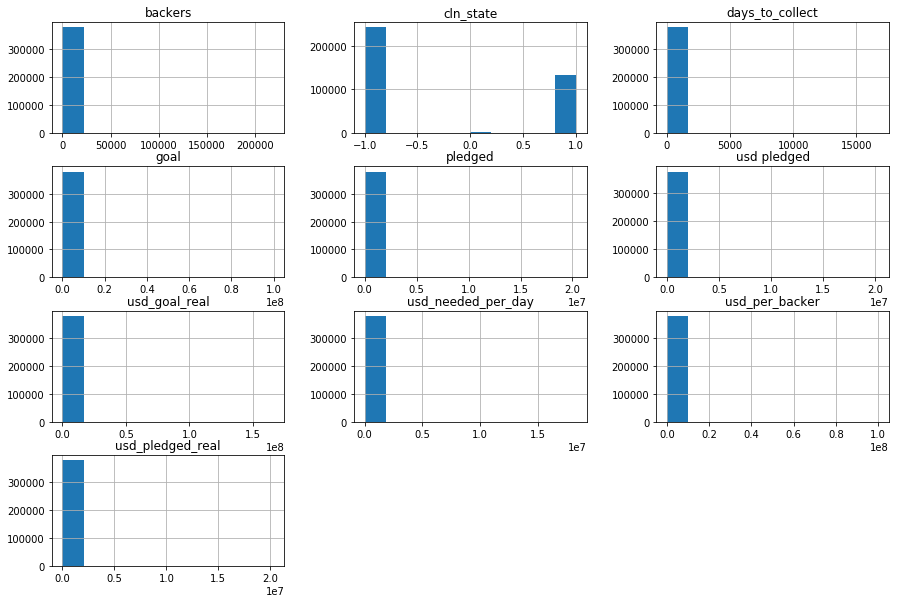

In [105]:
df.hist(figsize=(15,10));

The difference between the average and max value is huge. This means that there are serious outliers which we decided to delete (this will be done in the next step). The outliers will be removed by removing the data which is 3 or more standard deviations away from the mean.

In [106]:
cols = df.select_dtypes([np.number]).columns

In [113]:
df[cols] = df[cols].mask((df[cols] - df[cols].mean()).abs() > 3 * df[cols].std())
df = df.dropna()

Now all the data which is more than 3 standard devations away from the mean is removed.

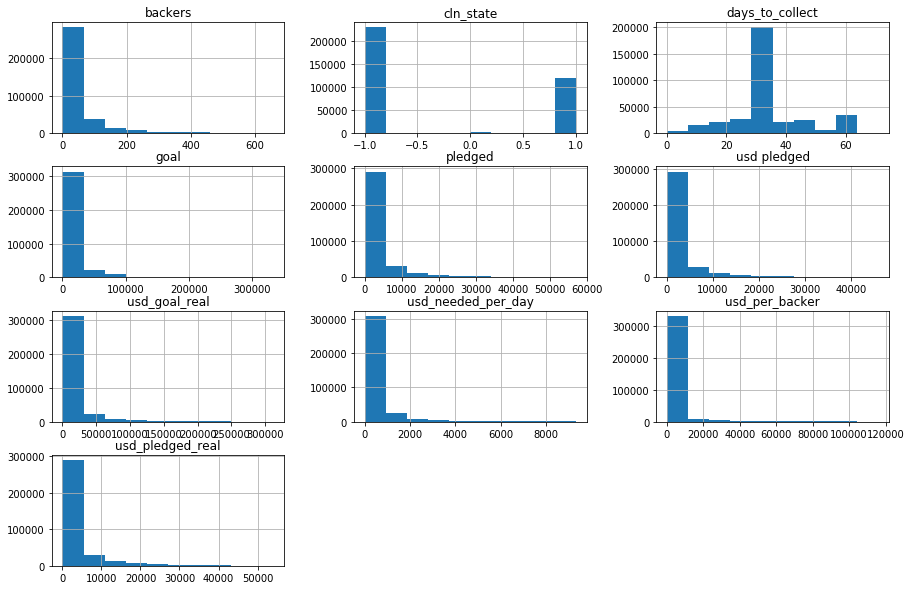

In [114]:
df.hist(figsize=(15,10));

In [115]:
df['cln_state'].unique()

array([-1.,  1.,  0.])

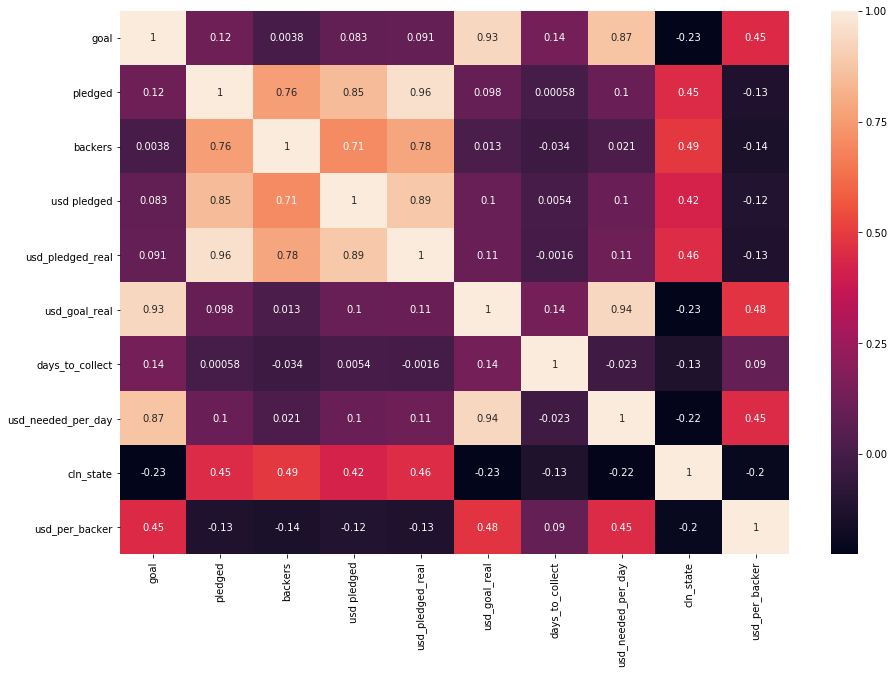

In [117]:
plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True)

In [17]:
df.groupby(by='category').corr()

backers  cln_state  days_to_collect  \
category                                                               
3D Printing backers             1.000000   0.273282        -0.016179   
            cln_state           0.273282   1.000000        -0.082564   
            days_to_collect    -0.016179  -0.082564         1.000000   
            goal                0.032955  -0.067804         0.159216   
            pledged             0.848110   0.326008         0.004378   
            usd pledged         0.848378   0.269618        -0.015943   
            usd_goal_real       0.031194  -0.093377         0.125447   
            usd_needed_per_day  0.038572  -0.081779         0.004521   
            usd_pledged_real    0.885677   0.308410         0.002297   
Academic    backers             1.000000   0.201668        -0.022836   
            cln_state           0.201668   1.000000        -0.114027   
            days_to_collect    -0.022836  -0.114027         1.000000   
            goal                0.000246  -0.029550        -0.013487   
            pledged             0.694319   0.180870        -0.044317   
            usd pledged         0.359962   0.353500         0.007843   
            usd_goal_real      -0.000461  -0.029821        -0.012970   
            usd_needed_per_day -0.000952  -0.027248        -0.032859   
            usd_pledged_real    0.989464   0.202186        -0.014977   
Accessories backers             1.000000   0.250395         0.066213   
            cln_state           0.250395   1.000000        -0.075571   
            days_to_collect     0.066213  -0.075571         1.000000   
            goal               -0.000610  -0.054099         0.093823   
            pledged             0.364545   0.159341         0.054968   
            usd pledged         0.752928   0.251005         0.074668   
            usd_goal_real       0.008135  -0.082954         0.110740   
            usd_needed_per_day  0.010231  -0.100891         0.042551   
            usd_pledged_real    0.775134   0.295694         0.099487   
Action      backers             1.000000   0.139840        -0.023389   
            cln_state           0.139840   1.000000        -0.178851   
            days_to_collect    -0.023389  -0.178851         1.000000   
...                                  ...        ...              ...   
Workshops   usd_goal_real      -0.049118  -0.219678         0.028862   
            usd_needed_per_day -0.041295  -0.203519        -0.087820   
            usd_pledged_real    0.836933   0.522135        -0.032739   
World Music backers             1.000000   0.194774        -0.015344   
            cln_state           0.194774   1.000000        -0.111114   
            days_to_collect    -0.015344  -0.111114         1.000000   
            goal               -0.000964  -0.039892         0.039816   
            pledged             0.966798   0.135340        -0.006224   
            usd pledged         0.510287   0.400876         0.008929   
            usd_goal_real      -0.000512  -0.038277         0.038247   
            usd_needed_per_day -0.001408  -0.030994        -0.025307   
            usd_pledged_real    0.972712   0.129986        -0.007487   
Young Adult backers             1.000000   0.475091        -0.055901   
            cln_state           0.475091   1.000000        -0.101572   
            days_to_collect    -0.055901  -0.101572         1.000000   
            goal               -0.012343  -0.021548        -0.011745   
            pledged             0.744041   0.453540        -0.050009   
            usd pledged         0.744164   0.379258        -0.038826   
            usd_goal_real      -0.015019  -0.031410        -0.017895   
            usd_needed_per_day -0.016185  -0.033031        -0.038994   
            usd_pledged_real    0.762444   0.439371        -0.050706   
Zines       backers             1.000000   0.336032        -0.054770   
            cln_state           0.336032   1.000000        -0.209254   
 